# SUPERVISED REGRESSION MODELLING: LOSS GIVEN DEFAULT

The objective of this model is to predict the percentage of the principal that will not be possible to recover from a loan that has been defaulted on.

\begin{equation*}
\text{target}_{\text{lgd}} = 
    \begin{cases}
      \dfrac{\text{Recovered amount}}{\text{Amount to be paid}} & if \, \text{Amount to be paid} > 1  \\
      0 & if \, \text{Amount to be paid} = 0
    \end{cases} 
\end{equation*}

## IMPORTING PACKAGES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

#Autocompletar rápido
%config IPCompleter.greedy=True

#Desactivar los warnings
import warnings
warnings.filterwarnings("ignore")

## DATA IMPORTATION

Replace project path.

In [2]:
project_path = '../..'

Names of data files.

In [3]:
df_name = 'df_input_lgd.pickle'

Data importation.

In [4]:
df = pd.read_pickle(project_path + '/02_Data/03_Work/' + df_name)

## MODELLING

In this section different combinations of algorithms/hyperparameters will be tested to find those with the best performance.

### Reserving validation dataset

In [6]:
x = df.drop(columns='target_lgd')
y = df.target_lgd.copy()

In [7]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)

### Creating the pipe and the dictionary of algorithms, parameters and values to be tested

In [8]:
pipe = Pipeline([('algoritmo',Ridge())])

grid = [      
        {'algoritmo': [Ridge()],
         'algoritmo__alpha': np.arange(0.1,1.1,0.1)},
        
        {'algoritmo': [Lasso()],
         'algoritmo__alpha': np.arange(0.1,1.1,0.1)},
    
        {'algoritmo': [HistGradientBoostingRegressor(min_samples_leaf = 100, scoring = 'neg_mean_absolute_error')],
         'algoritmo__learning_rate': [0.01,0.025,0.05,0.1],
         'algoritmo__max_iter': [50,100,200],
         'algoritmo__max_depth': [5,10,20],
         'algoritmo__l2_regularization': np.arange(0,1.25,0.25)}
       ]

### Hyperparameter optimization

#### Using grid search

In [9]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 3, 
                           scoring = 'neg_mean_absolute_error',
                           verbose = 3,
                           n_jobs = -1)

model = grid_search.fit(train_x.values,train_y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [10]:
pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algoritmo,param_algoritmo__alpha,param_algoritmo__l2_regularization,param_algoritmo__learning_rate,param_algoritmo__max_depth,param_algoritmo__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
163,63.829949,1.101277,1.481704,0.026938,HistGradientBoostingRegressor(l2_regularizatio...,NaN,0.75,0.1,20,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.373411,-0.371118,-0.371036,-0.371855,0.001101,1
196,57.862159,1.315491,1.100615,0.063222,HistGradientBoostingRegressor(l2_regularizatio...,NaN,1.0,0.1,10,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.376144,-0.369564,-0.371894,-0.372534,0.002724,2
199,51.401252,2.501788,0.805526,0.066369,HistGradientBoostingRegressor(l2_regularizatio...,NaN,1.0,0.1,20,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.372932,-0.373181,-0.371888,-0.372667,0.000560,3
127,64.187327,1.537409,1.425189,0.024953,HistGradientBoostingRegressor(l2_regularizatio...,NaN,0.5,0.1,20,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.375658,-0.371237,-0.371641,-0.372846,0.001996,4
88,69.000121,1.837778,1.539881,0.014859,HistGradientBoostingRegressor(l2_regularizatio...,NaN,0.25,0.1,10,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.372739,-0.371429,-0.374573,-0.372914,0.001290,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,0.277171,0.069896,0.014546,0.004524,Lasso(),0.8,NaN,NaN,NaN,NaN,"{'algoritmo': Lasso(), 'algoritmo__alpha': 0.8}",-0.487014,-0.487891,-0.487185,-0.487363,0.000380,191
18,0.395350,0.053199,0.010412,0.007362,Lasso(),0.9,NaN,NaN,NaN,NaN,"{'algoritmo': Lasso(), 'algoritmo__alpha': 0.9}",-0.487014,-0.487891,-0.487185,-0.487363,0.000380,191
19,0.357533,0.029615,0.005364,0.007255,Lasso(),1.0,NaN,NaN,NaN,NaN,"{'algoritmo': Lasso(), 'algoritmo__alpha': 1.0}",-0.487014,-0.487891,-0.487185,-0.487363,0.000380,191
11,0.239526,0.019484,0.000000,0.000000,Lasso(),0.2,NaN,NaN,NaN,NaN,"{'algoritmo': Lasso(), 'algoritmo__alpha': 0.2}",-0.487014,-0.487891,-0.487185,-0.487363,0.000380,191


LightGBM architecture is the one that is performing best.

In [12]:
model.best_estimator_

Pipeline(steps=[('algoritmo',
                 HistGradientBoostingRegressor(l2_regularization=0.75,
                                               max_depth=20, max_iter=200,
                                               min_samples_leaf=100,
                                               scoring='neg_mean_absolute_error'))])

Note that scores obtained in the tested algorithms/parametrisations remains stable during cross-validation process, which is a good indicator of the stability of the model predictions.

In [14]:
lgbm = HistGradientBoostingRegressor(learning_rate = 0.1,
                                     max_iter = 200,
                                     max_depth = 20,
                                     min_samples_leaf = 100,
                                     scoring = 'neg_mean_absolute_error',
                                     l2_regularization = 0.75)
lgbm.fit(train_x,train_y)

HistGradientBoostingRegressor(l2_regularization=0.75, max_depth=20,
                              max_iter=200, min_samples_leaf=100,
                              scoring='neg_mean_absolute_error')

## MODEL EVALUATION

Predicting on test dataset:

In [15]:
pred = lgbm.predict(val_x)

In [16]:
print('Max:',pred.max(),'\t Min:',pred.min())

Max: 1.261405063928991 	 Min: -0.0940958966463501


Given that the model's prediction is the percentage of the principal that will not be possible to recover from a loan that has been defaulted on, values must be between 0 and 1. However, the model may predict values outside this range so these cases must be corrected to avoid propagating such errors downstream.

In [17]:
pred = np.clip(pred, a_min=0, a_max=1)

In [18]:
print('Max:',pred.max(),'\t Min:',pred.min())

Max: 1.0 	 Min: 0.0


Evaluating on test dataset:

In [19]:
mean_absolute_error(val_y, pred)

0.37191639716426406

As can be seen, the error made by the model in predicting the loss level when default occurs is high. Nevertheless, it should be noted that errors in this type of risk acquisition models are generally significantly higher than those in behavioural models, marketing, customer management, etc., as much less customer information is available when running the model.

In the same vein, it should also be noted that both defaulting and non-defaulting borrowers are being modelled, as this information is not available for a new customer. Therefore, on many occasions the model will be trying to predict loss level of borrowers who are unlikely to default, which also explains the errors obtained in the modelling.

## MODEL REPORTING

Checking predictions:

In [20]:
check = pd.DataFrame({'lgd_true':val_y, 'lgd_pred':pred})

Checking the correlation between model predictions and actual values:

In [22]:
check.corr()

,lgd_true,lgd_pred
lgd_true,1.000000,0.522327
lgd_pred,0.522327,1.000000


Checking the similarity between the density function of the model predictions and the actual value of the target:

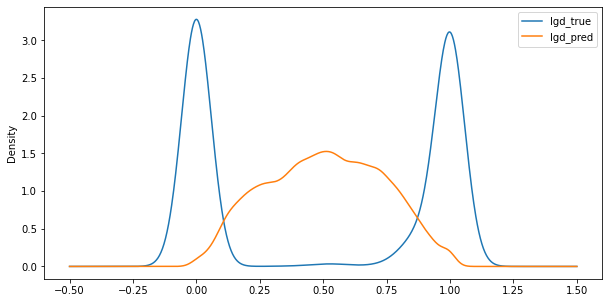

In [24]:
check.plot.density(figsize=(10,5));

It can be seen that in reality (lgd_true) two large groups can be distinguished: a group of loans in which no amount is recovered, either because the borrower has not defaulted or because the borrower has defaulted but the bank has not been able to recover any amount; and a second group of loans in which it has been possible to recover the full amount, either because the borrower has amortised the entire loan or because it has been possible to recover the full amount a defaulted loan.

Model's predictions tend towards intermediate loss levels, which leads to larger errors in predicting fully recovered or lost loans.

However, at an aggregate level from a business point of view the performance of the model is acceptable, as it will be covering the lost amount of loans in which the amount borrowed has been completely lost by predicting to most customers a loss level of between 25% and 75% even those who ultimately fully paid their loans, thus covering the aggregate risk of the client portfolio.